In [120]:
import os
import sys
import numpy as np
from io import BytesIO
import tempfile
from glob import glob
import gzip
import shutil

#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
import lsst.afw.fits as afwFits
import lsst.geom
import lsst.alert.packet
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.ticker as plticker
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.utils.console import ProgressBar
from astropy.nddata import CCDData


import fastavro
import seaborn as sns

In [112]:
sns.set_context('talk')


In [2]:
lsst.alert.packet

<module 'lsst.alert.packet' from '/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-1a1d771/Linux64/alert_packet/master-ge2bc8cbd00/python/lsst/alert/packet/__init__.py'>

In [3]:
#fastavro.schema._schema.SCHEMA_DEFS.clear()

In [4]:
!ls /project/morriscb/src/ap_verify_hits2015/DM-25930/alerts | head

41091501.avro
41091503.avro
41091504.avro
41091505.avro
41091506.avro
41091507.avro
41091508.avro
41091509.avro
41091510.avro
41091511.avro
ls: write error: Broken pipe


In [5]:
alert_files = glob('/project/morriscb/src/ap_verify_hits2015/DM-25930/alerts/*.avro')

In [6]:
len(alert_files)

5020

In [10]:
schema = lsst.alert.packet.Schema.from_file()

In [55]:
avro_file = alert_files[3]

In [15]:
with open(f'{avro_file}','rb') as f:
    ct = 0
    writer_schema, packet_iter = schema.retrieve_alerts(f)
    for packet in packet_iter:
        ct += 1
print(ct)

28


In [20]:
def read_cutout_images(alert):
    
    
    with BytesIO(alert['cutoutDifference']) as bytesIO:
        cutoutDifference = CCDData.read(bytesIO, format="fits")
        
    with BytesIO(alert['cutoutTemplate']) as bytesIO:
        cutoutTemplate = CCDData.read(bytesIO, format="fits")
   
    return cutoutDifference, cutoutTemplate
    

In [22]:
cutoutDifference, cutoutTemplate = read_cutout_images(packet)

In [24]:
cutoutDifference.shape

(60, 60)

https://stackoverflow.com/questions/26827055/python-how-to-get-iobytes-allocated-memory-length

In [28]:
sys.getsizeof(cutoutDifference)

64

In [40]:
%%time
sys.getsizeof(BytesIO(packet['cutoutDifference']).getvalue())

CPU times: user 13 µs, sys: 4 µs, total: 17 µs
Wall time: 24.3 µs


34593

In [37]:
%%time
BytesIO(packet['cutoutDifference']).getbuffer().nbytes

CPU times: user 26 µs, sys: 8 µs, total: 34 µs
Wall time: 41.7 µs


34560

In [35]:
BytesIO(packet['cutoutDifference']).__sizeof__()

64

In [38]:
%%time
len(BytesIO(packet['cutoutDifference']).getvalue())

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 22.6 µs


34560

In [49]:

def size_cutout(alert, cutoutType='Difference'):
    
    assert(cutoutType in ['Difference','Template'])
    
    with BytesIO(alert[f'cutout{cutoutType}']) as bytesIO:
        cutoutSizeBytes = len(bytesIO.getvalue())

        with fits.open(bytesIO) as hdulist:
            cutoutNAXIS1 = hdulist[0].header['NAXIS1']
            cutoutNAXIS2 = hdulist[0].header['NAXIS2']

    
    return cutoutSizeBytes, cutoutNAXIS1, cutoutNAXIS2, 


In [52]:
size_cutout(packet)

(34560, 60, 60)

In [56]:
%%time
with open(f'{avro_file}','rb') as f:
    writer_schema, packet_iter = schema.retrieve_alerts(f)
    for packet in packet_iter:
        print(size_cutout(packet,'Difference'))
        print(size_cutout(packet,'Template'))


(23040, 42, 42)
(23040, 42, 42)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(28800, 51, 51)
(28800, 51, 51)
(17280, 36, 36)
(17280, 36, 36)
(17280, 30, 30)
(17280, 30, 30)
(28800, 47, 47)
(28800, 47, 47)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(23040, 45, 45)
(23040, 45, 45)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(17280, 30, 30)
(23040, 45, 45)
(23040, 45, 45)
(17280, 30, 30)
(17280, 30, 30)
(28800, 49, 49)
(28800, 49, 49)
(17280, 30, 30)
(17280, 30, 30)
(17280, 

So as we expect right now the cutouts are square.
Both cutouts are also the same size for the same shape, which also is expected.

In [66]:
sizes_bytes = []
pixel_sizes = []

with ProgressBar(len(alert_files), ipython_widget=True) as bar:
    for avro_file in alert_files:
        with open(f'{avro_file}','rb') as f:
            writer_schema, packet_iter = schema.retrieve_alerts(f)
            for packet in packet_iter:
                size_bytes, size_pixels, _ = size_cutout(packet,'Difference')
                sizes_bytes.append(size_bytes)
                pixel_sizes.append(size_pixels)
        bar.update()
        
sizes_bytes_array = np.array(sizes_bytes)
pixel_sizes_array = np.array(pixel_sizes)
np.savez_compressed('alert_sizes.npz',sizes_bytes_array,pixel_sizes_array)

FloatProgress(value=0.0)

In [67]:
len(sizes_bytes_array)

673148

In [77]:
np.max(sizes_bytes_array)/1024/1024

506.151123046875

In [71]:
np.max(pixel_sizes_array)

8145

Text(0, 0.5, 'Number of cutouts')

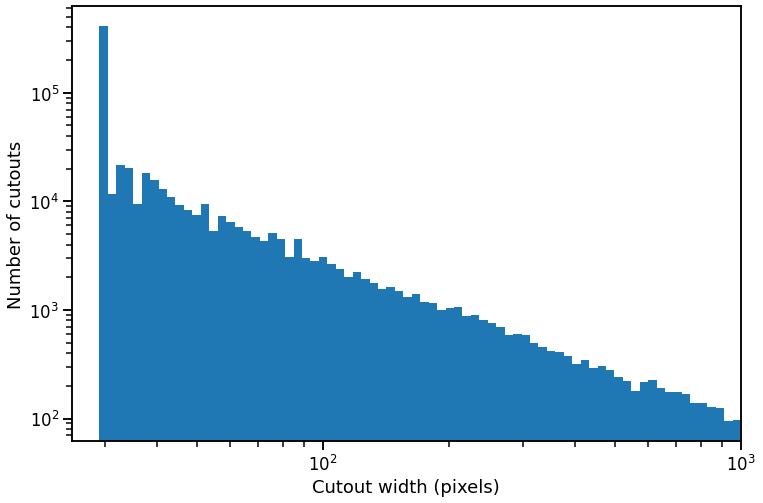

In [113]:
fig = plt.figure(figsize=(12,8))
_=plt.hist(pixel_sizes_array,bins=np.logspace(1,3,100))
plt.xscale('log')
plt.yscale('log')
plt.xlim(25,1000)
plt.xlabel('Cutout width (pixels)')
plt.ylabel('Number of cutouts')

Text(0, 0.5, 'Fraction of cutouts')

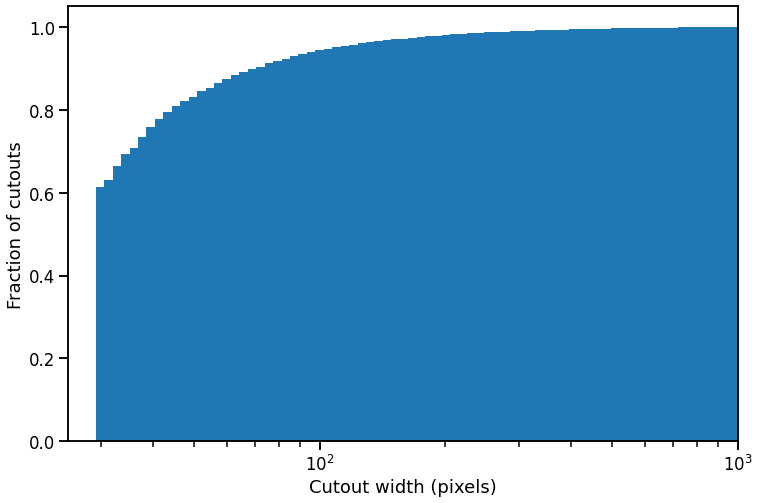

In [109]:
fig = plt.figure(figsize=(12,8))
_=plt.hist(pixel_sizes_array,bins=np.logspace(1,3,100),cumulative=True,density=True)
plt.xscale('log')
#plt.yscale('log')
plt.xlim(25,1000)
plt.xlabel('Cutout width (pixels)')
plt.ylabel('Fraction of cutouts')

In [125]:
np.sum(pixel_sizes_array > 1000)/len(pixel_sizes_array)

0.004088253994663878

Text(0, 0.5, 'Fraction of cutouts')

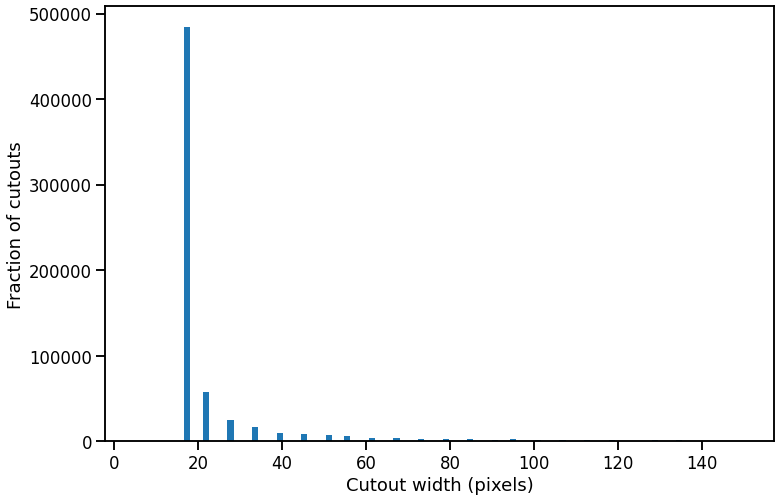

In [114]:
fig = plt.figure(figsize=(12,8))
_=plt.hist(sizes_bytes_array/1024,bins=np.linspace(5,150,100))#,cumulative=True)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(25,1000)
plt.xlabel('Cutout width (pixels)')
plt.ylabel('Fraction of cutouts')

In [94]:
np.percentile(sizes_bytes_array,[5,50,95])/1024

array([ 16.875,  16.875, 118.125])

In [97]:
np.min(sizes_bytes_array)/1024

16.875

In [98]:
np.max(sizes_bytes_array)/1024

518298.75

In [100]:
np.percentile(pixel_sizes_array,[5,50,95])

array([ 30.,  30., 117.])

In [101]:
np.max(pixel_sizes_array)

8145

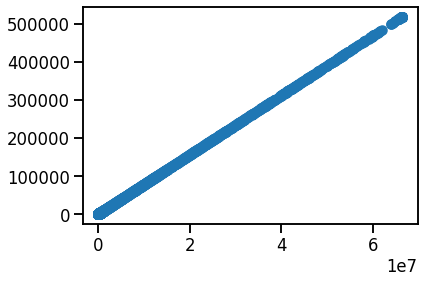

In [115]:
plt.scatter(pixel_sizes_array**2.,sizes_bytes_array/1024)

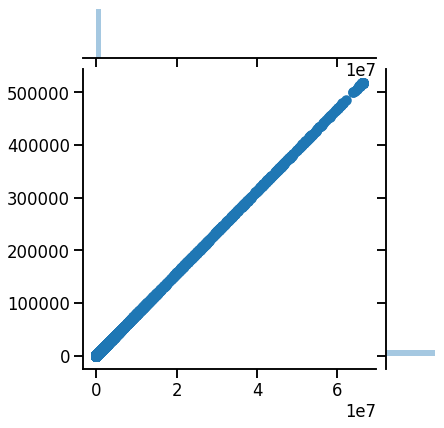

In [110]:
sns.jointplot(pixel_sizes_array**2.,sizes_bytes_array/1024)#,marginal_kws={'yscale':'log'})

### GZIP time

In [134]:
with open(f'{avro_file}','rb') as f:
    writer_schema, packet_iter = schema.retrieve_alerts(f)
    for packet in packet_iter:
        with BytesIO(packet['cutoutDifference']) as bio_in, BytesIO() as bio_out:
            with gzip.open(bio_out, 'wb') as f_out:
                shutil.copyfileobj(bio_in, f_out)
            bio_out.seek(0)
            size_bytes = len(bio_in.getvalue())
            size_bytes_gz = len(bio_out.getvalue())
            print(size_bytes, size_bytes_gz, size_bytes_gz/size_bytes)

17280 5067 0.29322916666666665
17280 7468 0.4321759259259259
17280 6612 0.38263888888888886
17280 6291 0.3640625
17280 7451 0.4311921296296296
17280 7448 0.4310185185185185
17280 7453 0.4313078703703704
17280 5597 0.323900462962963
17280 7512 0.43472222222222223
17280 7439 0.43049768518518516
17280 7426 0.42974537037037036
17280 9861 0.5706597222222223
17280 7441 0.43061342592592594
17280 6771 0.3918402777777778
17280 7529 0.43570601851851853
17280 5259 0.3043402777777778
23040 13873 0.6021267361111111
17280 7533 0.4359375
40320 30369 0.7531994047619047
23040 12044 0.5227430555555556
23040 12662 0.5495659722222223
17280 7481 0.43292824074074077
17280 8889 0.5144097222222223
17280 7513 0.4347800925925926
17280 7516 0.43495370370370373
28800 15481 0.5375347222222222
17280 7464 0.43194444444444446
17280 7441 0.43061342592592594
17280 7430 0.42997685185185186
17280 7422 0.42951388888888886
17280 7468 0.4321759259259259
17280 7544 0.43657407407407406
17280 7550 0.4369212962962963
17280 7447